In [1]:
#Importações das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

#Ignorar avisos
warnings.filterwarnings("ignore")

In [22]:
# Carregar os datasets
print("Carregando dados...")
transactions = pd.read_csv("transactions.csv")
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")


Carregando dados...


In [24]:
# Com esse comando conseguimos verificar qual o tipo de dado de cada coluna.
print(transactions.dtypes, '\n')

print(customers.dtypes, '\n')

print(products.dtypes, '\n')

transaction_id        int64
customer_id           int64
product_id            int64
transaction_date     object
quantity              int64
price               float64
total_value         float64
dtype: object 

customer_id           int64
age                   int64
gender               object
city                 object
registration_date    object
phone_number         object
dtype: object 

product_id       int64
category        object
price          float64
partnership     object
dtype: object 



In [25]:
# Converter tipos de dados
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
customers["registration_date"] = pd.to_datetime(customers["registration_date"])

In [26]:
# Merge dos dataframes
df = transactions.merge(products, on="product_id", how="left")
df = df.merge(customers, on="customer_id", how="left")

df.head()

,transaction_id,customer_id,product_id,transaction_date,quantity,price_x,total_value,category,price_y,partnership,age,gender,city,registration_date,phone_number
0,1244273,35981,333,2021-01-01,1,415.53,415.53,Casa,415.53,Partner_A,69,Other,Rio de Janeiro,2019-02-10,(31) 96967-8127
1,212802,54995,282,2021-01-01,4,332.27,1329.08,Moda,332.27,Partner_C,59,Female,Porto Alegre,2018-12-14,(21) 99360-5246
2,1598055,21228,478,2021-01-01,2,92.21,184.42,Moda,92.21,Partner_C,64,Female,São Paulo,2020-12-17,(11) 95934-9756
3,2219068,480672,11,2021-01-01,3,282.79,848.37,Moda,282.79,Partner_C,64,Other,Rio de Janeiro,2019-11-16,(81) 99350-9984
4,952766,151706,14,2021-01-01,2,475.22,950.44,Casa,475.22,Partner_A,59,Male,Rio de Janeiro,2019-09-27,(31) 92498-4566


In [27]:
df.isnull().sum()

transaction_id       0
customer_id          0
product_id           0
transaction_date     0
quantity             0
price_x              0
total_value          0
category             0
price_y              0
partnership          0
age                  0
gender               0
city                 0
registration_date    0
phone_number         0
dtype: int64

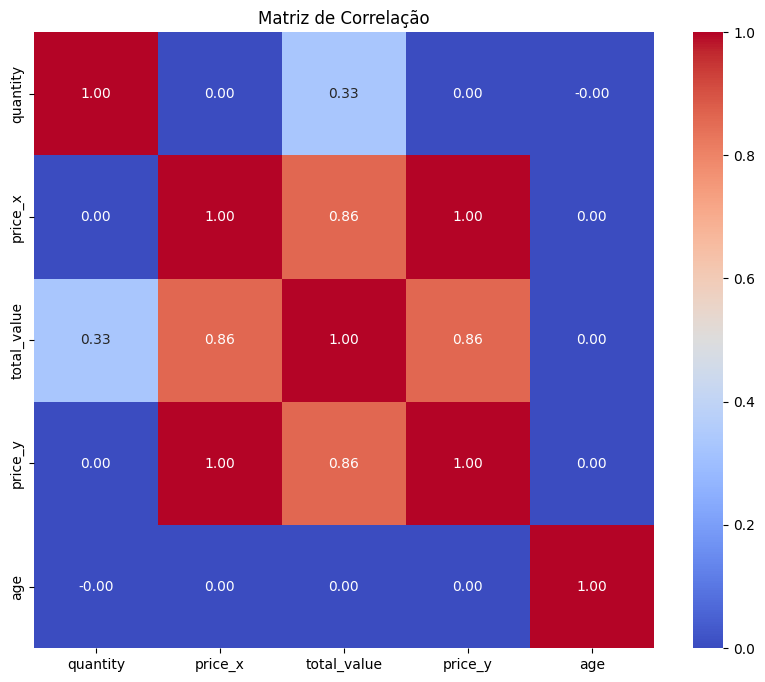

In [28]:
correlacao = df.drop(columns=['transaction_id','customer_id','product_id'])
correlacao = correlacao.select_dtypes(include=['number']).corr()
# Plotar o mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de Correlação')
plt.show()

In [29]:
# Calcular receita da plataforma
def calcular_receita_plataforma(row):
    if row["category"] == "Eletrônicos":
        return row["total_value"] * 0.01
    elif row["category"] in ["Esportes", "Livros"]:
        return row["total_value"] * 0.03
    elif row["category"] == "Casa":
        return row["total_value"] * 0.04
    elif row["category"] == "Moda":
        return 10.00 * row["quantity"]
    return 0

#calculando a receita da plataforma
df["receita_plataforma"] = df.apply(calcular_receita_plataforma, axis=1)

df.head()

,transaction_id,customer_id,product_id,transaction_date,quantity,price_x,total_value,category,price_y,partnership,age,gender,city,registration_date,phone_number,receita_plataforma
0,1244273,35981,333,2021-01-01,1,415.53,415.53,Casa,415.53,Partner_A,69,Other,Rio de Janeiro,2019-02-10,(31) 96967-8127,16.6212
1,212802,54995,282,2021-01-01,4,332.27,1329.08,Moda,332.27,Partner_C,59,Female,Porto Alegre,2018-12-14,(21) 99360-5246,40.0000
2,1598055,21228,478,2021-01-01,2,92.21,184.42,Moda,92.21,Partner_C,64,Female,São Paulo,2020-12-17,(11) 95934-9756,20.0000
3,2219068,480672,11,2021-01-01,3,282.79,848.37,Moda,282.79,Partner_C,64,Other,Rio de Janeiro,2019-11-16,(81) 99350-9984,30.0000
4,952766,151706,14,2021-01-01,2,475.22,950.44,Casa,475.22,Partner_A,59,Male,Rio de Janeiro,2019-09-27,(31) 92498-4566,38.0176


## Parte 1: Análise Exploratória de Dados (AED)
Nesta seção, exploramos os dados para responder às seguintes questões de negócio:

* Quais categorias de produtos apresentam maior ticket médio, volume e valor de vendas?
* Qual categoria traz maior receita própria para a plataforma?
* Em que cidades se concentram os maiores valores de vendas?
* Quais parceiros são responsáveis pelos maiores volumes de vendas e receita?
* Quais outras métricas podem ser usadas para avaliar a performance do negócio?

In [31]:
# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


print(f"Período: {transactions['transaction_date'].min()} a {transactions['transaction_date'].max()}")
pd.options.display.float_format = '{:,.2f}'.format

# ============================================
# ANÁLISE 1: CATEGORIAS
# ============================================
print("\n" + "="*60)
print("ANÁLISE 1: CATEGORIAS DE PRODUTOS")
print("="*60)

analise_categoria = df.groupby('category').agg({
    'transaction_id': 'count',
    'total_value': 'sum',
    'receita_plataforma': 'sum'
}).round(2)

analise_categoria.columns = ['Volume_Vendas', 'Valor_Total_Vendas', 'Receita_Plataforma']
analise_categoria['Ticket_Medio'] = (analise_categoria['Valor_Total_Vendas'] / analise_categoria['Volume_Vendas']).round(2)
analise_categoria = analise_categoria.sort_values('Valor_Total_Vendas', ascending=False)

print("\nMétricas por Categoria:")
print(analise_categoria)

print(f"\n✓ Maior Ticket Médio: {analise_categoria['Ticket_Medio'].idxmax()} (R$ {analise_categoria['Ticket_Medio'].max():,.2f})")
print(f"✓ Maior Volume de Vendas: {analise_categoria['Volume_Vendas'].idxmax()} ({analise_categoria['Volume_Vendas'].max():,} transações)")
print(f"✓ Maior Valor Transacionado: {analise_categoria['Valor_Total_Vendas'].idxmax()} (R$ {analise_categoria['Valor_Total_Vendas'].max():,.2f})")
print(f"✓ Maior Receita para Plataforma: {analise_categoria['Receita_Plataforma'].idxmax()} (R$ {analise_categoria['Receita_Plataforma'].max():,.2f})")

# ============================================
# ANÁLISE 2: CIDADES
# ============================================
print("\n" + "="*60)
print("ANÁLISE 2: CONCENTRAÇÃO POR CIDADE")
print("="*60)

analise_cidade = df.groupby('city').agg({
    'total_value': 'sum',
    'transaction_id': 'count',
    'receita_plataforma': 'sum'
}).round(2)

analise_cidade.columns = ['Valor_Total_Vendas', 'Volume_Vendas', 'Receita_Plataforma']
analise_cidade = analise_cidade.sort_values('Valor_Total_Vendas', ascending=False)

print("\nTop Cidades por Valor de Vendas:")
print(analise_cidade.head(10))

# ============================================
# ANÁLISE 3: PARCEIROS
# ============================================
print("\n" + "="*60)
print("ANÁLISE 3: PERFORMANCE DOS PARCEIROS")
print("="*60)

analise_parceiro = df.groupby('partnership').agg({
    'transaction_id': 'count',
    'total_value': 'sum',
    'receita_plataforma': 'sum'
}).round(2)

analise_parceiro.columns = ['Volume_Vendas', 'Valor_Total_Vendas', 'Receita_Plataforma']
analise_parceiro = analise_parceiro.sort_values('Volume_Vendas', ascending=False)

print("\nMétricas por Parceiro:")
print(analise_parceiro)

print(f"\n✓ Maior Volume de Vendas: {analise_parceiro['Volume_Vendas'].idxmax()} ({analise_parceiro['Volume_Vendas'].max():,} transações)")
print(f"✓ Maior Receita para Plataforma: {analise_parceiro['Receita_Plataforma'].idxmax()} (R$ {analise_parceiro['Receita_Plataforma'].max():,.2f})")

# ============================================
# ANÁLISE 4: MÉTRICAS ADICIONAIS
# ============================================
print("\n" + "="*60)
print("ANÁLISE 4: MÉTRICAS ADICIONAIS DE PERFORMANCE")
print("="*60)

# Taxa de recompra
volume_compra = df.groupby('customer_id')['transaction_id'].count()
recompra_cliente = (volume_compra > 1).sum()
total_cliente = df['customer_id'].nunique()
taxa_repeticao = (recompra_cliente / total_cliente) * 100

print(f"\n1. Taxa de Recompra:")
print(f"   - Clientes que compraram: {total_cliente:,}")
print(f"   - Clientes que recompraram: {recompra_cliente:,}")
print(f"   - Taxa de recompra: {taxa_repeticao:.2f}%")

# Frequência média de compra
media_compra = volume_compra.mean()
print(f"\n2. Frequência de Compra:")
print(f"   - Média de compras por cliente: {media_compra:.2f}")
print(f"   - Mediana de compras por cliente: {volume_compra.median():.0f}")

# Análise temporal
df['ano_mes'] = df['transaction_date'].dt.to_period('M')
vendas_mensais = df.groupby('ano_mes').agg({
    'total_value': 'sum',
    'transaction_id': 'count',
    'receita_plataforma': 'sum'
})

print(f"\n3. Crescimento Temporal:")
print(f"   - Período analisado: {df['transaction_date'].min().strftime('%Y-%m-%d')} a {df['transaction_date'].max().strftime('%Y-%m-%d')}")
print(f"   - Vendas mensais médias: R$ {vendas_mensais['total_value'].mean():,.2f}")
print(f"   - Receita mensal média da plataforma: R$ {vendas_mensais['receita_plataforma'].mean():,.2f}")

# Mix de produtos
mix_categorias = df.groupby('category')['transaction_id'].count()
mix_categorias_porcentagem = (mix_categorias / mix_categorias.sum() * 100).round(2)

print(f"\n4. Mix de Produtos (% do volume):")
for categoria, porcentagem in mix_categorias_porcentagem.sort_values(ascending=False).items():
    print(f"   - {categoria}: {porcentagem}%")


print("\n" + "="*60)
print("Análise exploratória concluída!")
print("="*60)


Período: 2021-01-01 00:00:00 a 2024-12-31 00:00:00

ANÁLISE 1: CATEGORIAS DE PRODUTOS

Métricas por Categoria:
             Volume_Vendas  Valor_Total_Vendas  Receita_Plataforma  \
category                                                             
Eletrônicos         302593    2,096,040,598.13       20,960,405.98   
Esportes            585780    1,580,282,116.53       47,408,463.50   
Casa                564365      780,902,637.02       31,236,105.48   
Moda               1211223      748,952,110.41       30,298,270.00   
Livros              336039      176,823,269.36        5,304,698.08   

             Ticket_Medio  
category                   
Eletrônicos      6,926.93  
Esportes         2,697.74  
Casa             1,383.68  
Moda               618.34  
Livros             526.20  

✓ Maior Ticket Médio: Eletrônicos (R$ 6,926.93)
✓ Maior Volume de Vendas: Moda (1,211,223 transações)
✓ Maior Valor Transacionado: Eletrônicos (R$ 2,096,040,598.13)
✓ Maior Receita para Plataforma: Esp

Criando visualização 1: Análise por Categoria...
Criando visualização 2: Análise por Cidade...
Criando visualização 3: Análise por Parceiro...
Criando visualização 5: Heatmap Parceiro x Categoria...


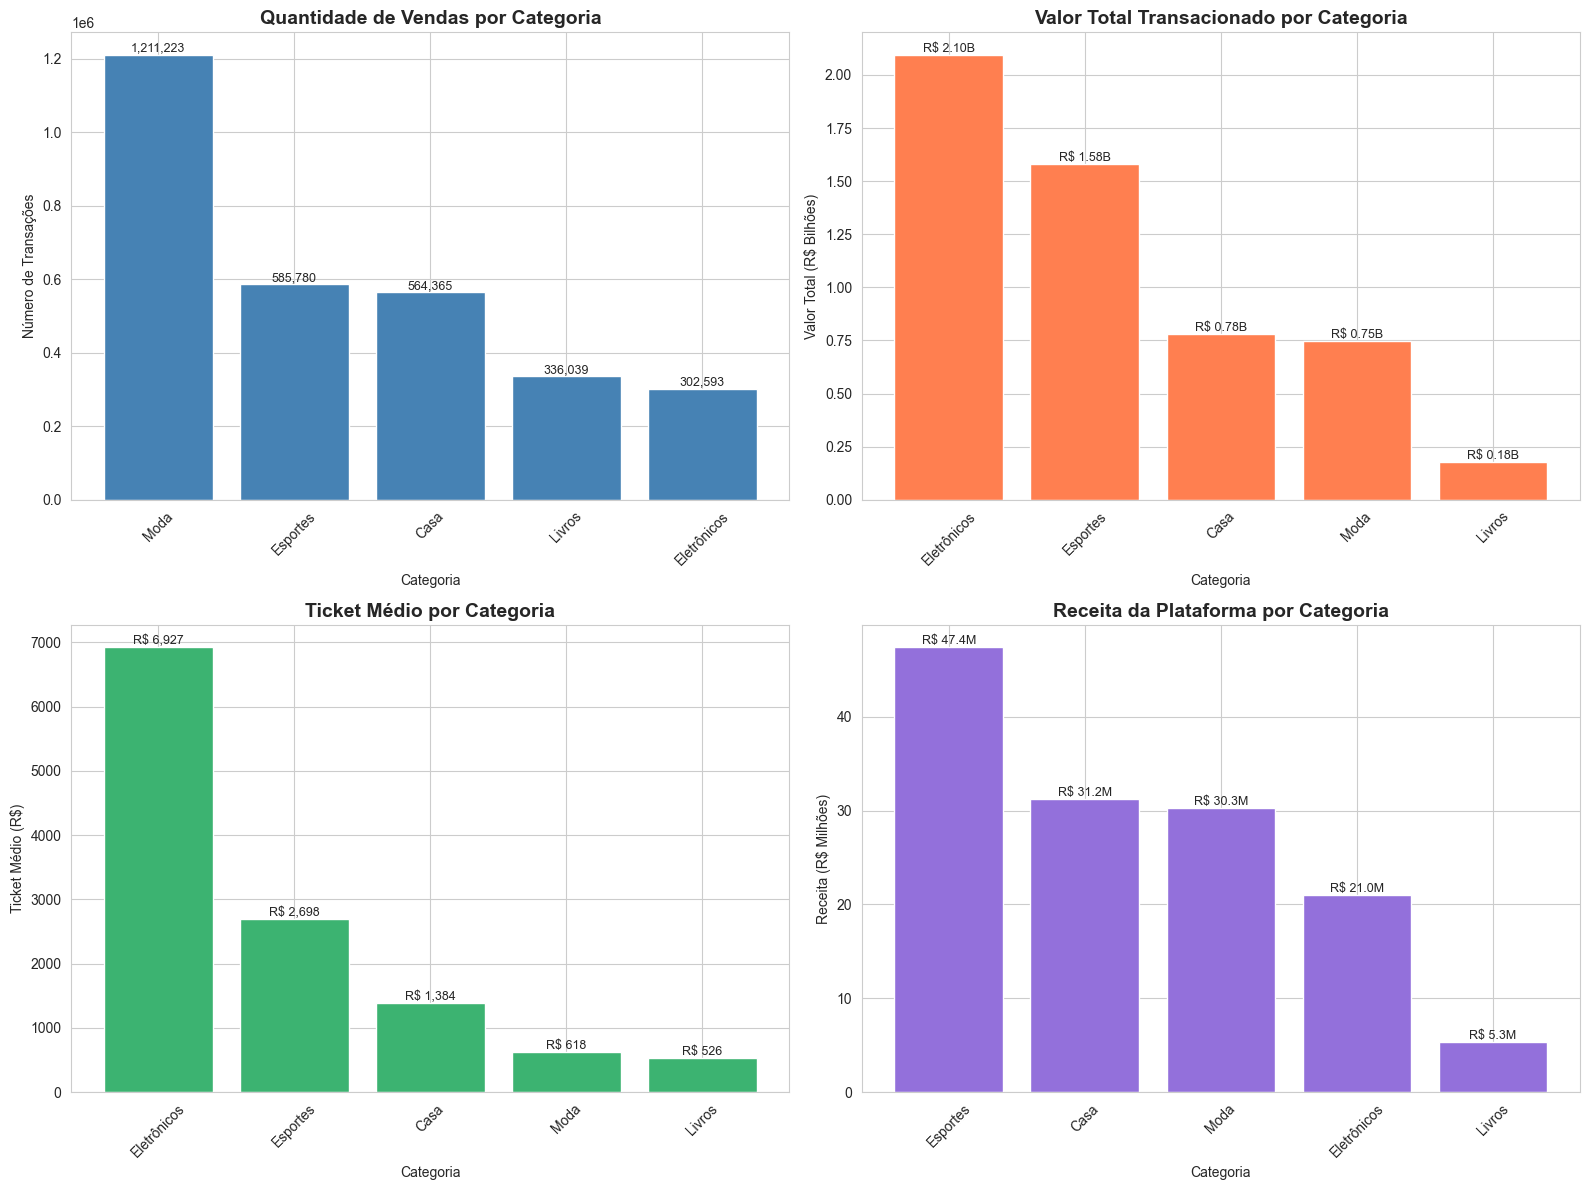

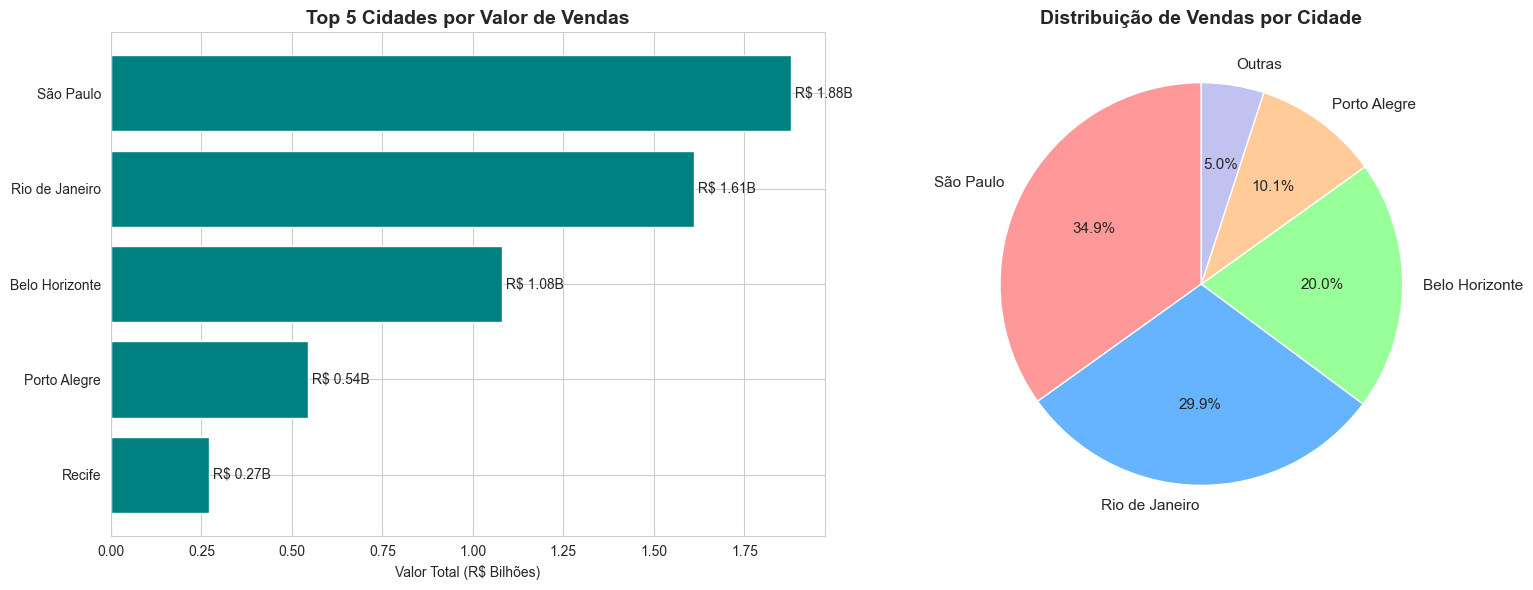

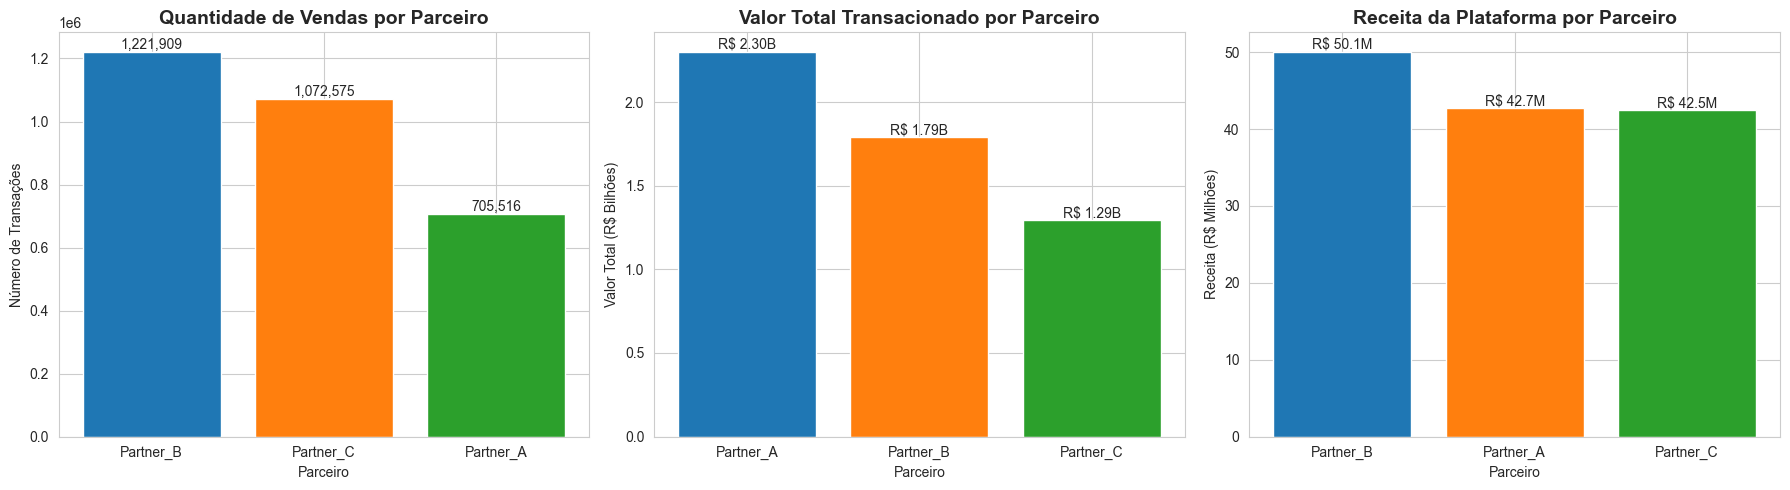

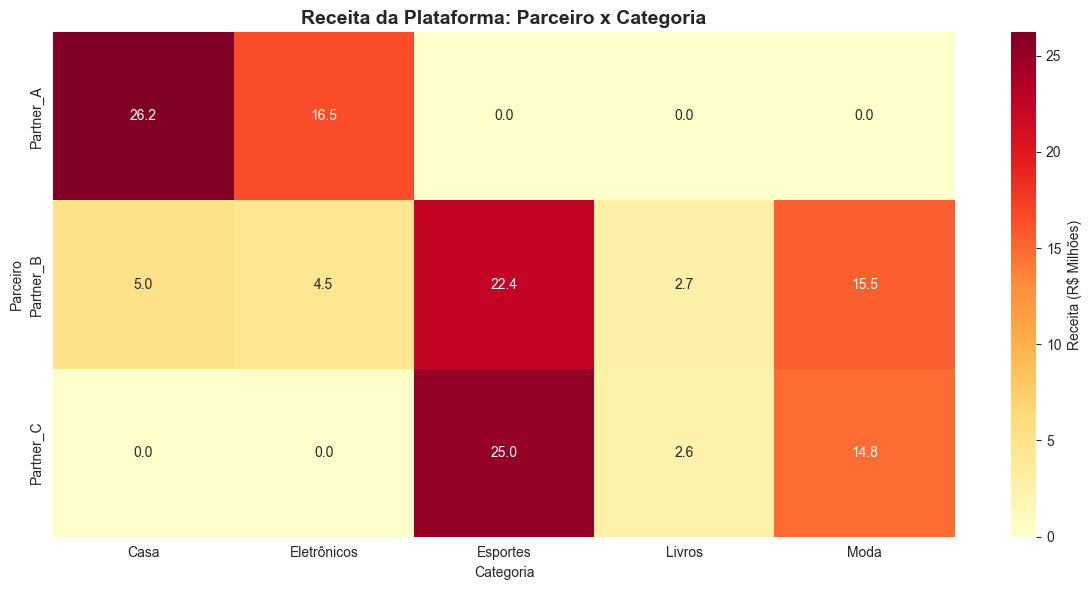

In [32]:

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


# ============================================
# VISUALIZAÇÃO 1: Análise por Categoria
# ============================================
print("Criando visualização 1: Análise por Categoria...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1 Volume de vendas por categoria
quantidade_categoria = df.groupby('category')['transaction_id'].count().sort_values(ascending=False)
axes[0, 0].bar(quantidade_categoria.index, quantidade_categoria.values, color='steelblue')
axes[0, 0].set_title('Quantidade de Vendas por Categoria', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Categoria')
axes[0, 0].set_ylabel('Número de Transações')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(quantidade_categoria.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 1.2 Valor total transacionado por categoria
vendas_categoria = df.groupby('category')['total_value'].sum().sort_values(ascending=False) / 1e9
axes[0, 1].bar(vendas_categoria.index, vendas_categoria.values, color='coral')
axes[0, 1].set_title('Valor Total Transacionado por Categoria', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Categoria')
axes[0, 1].set_ylabel('Valor Total (R$ Bilhões)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(vendas_categoria.values):
    axes[0, 1].text(i, v, f'R$ {v:.2f}B', ha='center', va='bottom', fontsize=9)

# 1.3 Ticket médio por categoria
ticket_categoria = df.groupby('category')['total_value'].sum() / df.groupby('category')['transaction_id'].count()
ticket_categoria = ticket_categoria.sort_values(ascending=False)
axes[1, 0].bar(ticket_categoria.index, ticket_categoria.values, color='mediumseagreen')
axes[1, 0].set_title('Ticket Médio por Categoria', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Categoria')
axes[1, 0].set_ylabel('Ticket Médio (R$)')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(ticket_categoria.values):
    axes[1, 0].text(i, v, f'R$ {v:,.0f}', ha='center', va='bottom', fontsize=9)

# 1.4 Receita da plataforma por categoria
receita_categoria = df.groupby('category')['receita_plataforma'].sum().sort_values(ascending=False) / 1e6
axes[1, 1].bar(receita_categoria.index, receita_categoria.values, color='mediumpurple')
axes[1, 1].set_title('Receita da Plataforma por Categoria', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Categoria')
axes[1, 1].set_ylabel('Receita (R$ Milhões)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(receita_categoria.values):
    axes[1, 1].text(i, v, f'R$ {v:.1f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# ============================================
# VISUALIZAÇÃO 2: Análise por Cidade
# ============================================
print("Criando visualização 2: Análise por Cidade...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2.1 Top 5 cidades por valor de vendas
vendas_cidade = df.groupby('city')['total_value'].sum().sort_values(ascending=False).head(5) / 1e9
axes[0].barh(range(len(vendas_cidade)), vendas_cidade.values, color='teal')
axes[0].set_yticks(range(len(vendas_cidade)))
axes[0].set_yticklabels(vendas_cidade.index)
axes[0].set_title('Top 5 Cidades por Valor de Vendas', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Valor Total (R$ Bilhões)')
axes[0].invert_yaxis()
for i, v in enumerate(vendas_cidade.values):
    axes[0].text(v, i, f' R$ {v:.2f}B', va='center', fontsize=10)

# 2.2 Distribuição percentual por cidade
cidade_porcentagem = df.groupby('city')['total_value'].sum().sort_values(ascending=False)
top_cidades = cidade_porcentagem.head(4)
outros = pd.Series({'Outras': cidade_porcentagem[4:].sum()})
pizza_cidade = pd.concat([top_cidades, outros])

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
axes[1].pie(pizza_cidade.values, labels=pizza_cidade.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 11})
axes[1].set_title('Distribuição de Vendas por Cidade', fontsize=14, fontweight='bold')

plt.tight_layout()

# ============================================
# VISUALIZAÇÃO 3: Análise por Parceiro
# ============================================
print("Criando visualização 3: Análise por Parceiro...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3.1 Quantidade de vendas por parceiro
quantidade_parceiro = df.groupby('partnership')['transaction_id'].count().sort_values(ascending=False)
axes[0].bar(quantidade_parceiro.index, quantidade_parceiro.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Quantidade de Vendas por Parceiro', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Parceiro')
axes[0].set_ylabel('Número de Transações')
for i, v in enumerate(quantidade_parceiro.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)

# 3.2 Valor total por parceiro
vendas_parceiro = df.groupby('partnership')['total_value'].sum().sort_values(ascending=False) / 1e9
axes[1].bar(vendas_parceiro.index, vendas_parceiro.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Valor Total Transacionado por Parceiro', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Parceiro')
axes[1].set_ylabel('Valor Total (R$ Bilhões)')
for i, v in enumerate(vendas_parceiro.values):
    axes[1].text(i, v, f'R$ {v:.2f}B', ha='center', va='bottom', fontsize=10)

# 3.3 Receita da plataforma por parceiro
receita_parceiro = df.groupby('partnership')['receita_plataforma'].sum().sort_values(ascending=False) / 1e6
axes[2].bar(receita_parceiro.index, receita_parceiro.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[2].set_title('Receita da Plataforma por Parceiro', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Parceiro')
axes[2].set_ylabel('Receita (R$ Milhões)')
for i, v in enumerate(receita_parceiro.values):
    axes[2].text(i, v, f'R$ {v:.1f}M', ha='center', va='bottom', fontsize=10)

plt.tight_layout()


# ============================================
# VISUALIZAÇÃO 4: Heatmap Parceiro x Categoria
# ============================================
print("Criando visualização 5: Heatmap Parceiro x Categoria...")

categoria_parceiro = df.groupby(['partnership', 'category'])['receita_plataforma'].sum().unstack(fill_value=0) / 1e6

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(categoria_parceiro, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Receita (R$ Milhões)'}, ax=ax)
ax.set_title('Receita da Plataforma: Parceiro x Categoria', fontsize=14, fontweight='bold')
ax.set_xlabel('Categoria')
ax.set_ylabel('Parceiro')

plt.tight_layout()

plt.show()

## Parte 2: Desenvolva um modelo preditivo (Machine Learning) capaz de prever: A chance de um cliente voltar a comprar nos próximos 60 dias


In [34]:
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, 
                             precision_score, recall_score, 
                             classification_report)



df_modelo = df.sort_values(['customer_id', 'transaction_date']).reset_index(drop=True)

print(f"Total de transações: {len(df_modelo):,}")
print(f"Total de clientes: {df_modelo['customer_id'].nunique():,}")
print(f"Período: {df_modelo['transaction_date'].min()} a {df_modelo['transaction_date'].max()}")


print(f"\nApós amostragem (20% dos clientes):")
print(f"Transações: {len(df_modelo):,}")
print(f"Clientes: {df_modelo['customer_id'].nunique():,}")

Total de transações: 3,000,000
Total de clientes: 498,724
Período: 2021-01-01 00:00:00 a 2024-12-31 00:00:00

Após amostragem (20% dos clientes):
Transações: 3,000,000
Clientes: 498,724


In [35]:
print("\n[2/8] Preparando funções de feature engineering...")

def construcao_features(df, corte_data):
    """
    Constrói features  para cada cliente até a data de corte.
    """
    df = df_modelo.copy()
    df["transaction_date"] = pd.to_datetime(df["transaction_date"])
    corte_data = pd.to_datetime(corte_data)
    
    # Filtrar apenas transações ANTES da data de corte
    hist = df[df["transaction_date"] < corte_data].copy()
    
    if len(hist) == 0:
        return pd.DataFrame()
    
    # FEATURES
    agg = hist.groupby("customer_id").agg(
        qtd_compras=("transaction_id", "count"),
        qtd_produtos=("product_id", "nunique"),
        valor_total=("total_value", "sum"),
        ticket_medio=("total_value", "mean"),
        ultima_compra=("transaction_date", "max"),
        primeira_compra=("transaction_date", "min"),
        qtd_categorias=("category", "nunique"),
    ).reset_index()
    
    # Recência (dias desde a última compra até o corte)
    agg["recencia"] = (corte_data - agg["ultima_compra"]).dt.days
    
    # Idade do relacionamento
    agg["idade_cliente"] = (corte_data - agg["primeira_compra"]).dt.days
    
    # Intervalo médio entre compras
    def media_intervalo_compras(data):
        data = data.sort_values()
        if len(data) <= 1:
            return np.nan
        return data.diff().dt.days.iloc[1:].mean()
    
    ip = hist.groupby("customer_id")["transaction_date"].apply(media_intervalo_compras)
    agg["intervalo_medio"] = agg["customer_id"].map(ip)
    
    # FEATURES
    
    # Intervalo de Recencia 
    agg["razao_recencia_intervalo"] = agg["recencia"] / (agg["intervalo_medio"] + 1)
    
    # Frequência de compras (compras por dia de relacionamento)
    agg["freq_compras"] = agg["qtd_compras"] / (agg["idade_cliente"] + 1)
    
    # Parceiros Únicos
    parceiros_unicos = hist.groupby("customer_id")["partnership"].nunique()
    agg["qtd_parceiros"] = agg["customer_id"].map(parceiros_unicos).fillna(0)
    
    
    # Mês da última compra
    agg["mes_ultima_compra"] = agg["ultima_compra"].dt.month
    
    
    # Merge com dados cadastrais
    if not customers.empty and 'customer_id' in customers.columns:
        cadastro = customers[["customer_id", "age", "gender", "city"]].copy()
        agg = agg.merge(cadastro, on="customer_id", how="left")
    
    # Preencher nulo
    agg = agg.fillna(0)
    
    return agg

print("✓ Função de features criada com sucesso!")


[2/8] Preparando funções de feature engineering...
✓ Função de features criada com sucesso!


In [36]:
def construcao_target(df, corte_data, horizon=60):
    """
    Constrói a target: cliente comprou nos próximos 60 dias após a data de corte?
    """
    df = df.copy()
    df["transaction_date"] = pd.to_datetime(df["transaction_date"])
    corte_data = pd.to_datetime(corte_data)
    
    futuro_comeco = corte_data
    futuro_fim = corte_data + pd.Timedelta(days=horizon)
    
    # Compras após corte de data
    df_futuro = df[
        (df["transaction_date"] > futuro_comeco) &
        (df["transaction_date"] <= futuro_fim)
    ]
    
    # Clientes que compraram no futuro
    clientes_que_compraram = df_futuro["customer_id"].unique()
    
    # Clientes que existiam antes do corte
    all_customers = df[df["transaction_date"] < corte_data]["customer_id"].unique()
    
    target_df = pd.DataFrame({"customer_id": all_customers})
    target_df["target"] = target_df["customer_id"].isin(clientes_que_compraram).astype(int)
    
    return target_df

print("✓ Função de target criada com sucesso!")

✓ Função de target criada com sucesso!


In [37]:
print("\n[3/8] Criando múltiplos snapshots temporais...")

# Definir datas de corte (a cada 3 meses)
min_date = df_modelo["transaction_date"].min()
max_date = df_modelo["transaction_date"].max()

# Pegando pelo menos 180 dias para as features terem um histórico razoável
primeiro_corte = min_date + pd.Timedelta(days=180)
ultimo_corte = max_date - pd.Timedelta(days=60)  # 60 dias para target

# Gerar corte de data a cada 90 dias
corte_datas = pd.date_range(start=primeiro_corte, end=ultimo_corte, freq='90D')

print(f"Número de snapshots: {len(corte_datas)}")
print(f"Primeiro corte: {corte_datas[0]}")
print(f"Último corte: {corte_datas[-1]}")

# Gerar datasets para cada corte
todos_datasets = []

for i, corte in enumerate(corte_datas):
    print(f"  Processando corte {i+1}/{len(corte_datas)}: {corte.date()}...", end="\r")
    
    features = construcao_features(df_modelo, corte)
    if len(features) == 0:
        continue
    
    target = construcao_target(df_modelo, corte, horizon=60)
    
    dataset = features.merge(target, on="customer_id", how="inner")
    dataset["corte_data"] = corte
    
    todos_datasets.append(dataset)

# Concatenar todos os cortes
full_dataset = pd.concat(todos_datasets, ignore_index=True)

print(f"\n\nDataset final:")
print(f"Total de observações: {len(full_dataset):,}")
print(f"Total de clientes únicos: {full_dataset['customer_id'].nunique():,}")
print(f"Número de features: {len(full_dataset.columns) - 3}")


[3/8] Criando múltiplos snapshots temporais...
Número de snapshots: 14
Primeiro corte: 2021-06-30 00:00:00
Último corte: 2024-09-12 00:00:00
  Processando corte 14/14: 2024-09-12...

Dataset final:
Total de observações: 6,230,469
Total de clientes únicos: 498,039
Número de features: 17


In [38]:
print("\n[4/8] Analisando distribuição da target...")

target_distinto = full_dataset["target"].value_counts()
target_percentual = full_dataset["target"].value_counts(normalize=True) * 100

print(f"\nDistribuição da target:")
print(f"Não recomprou (0): {target_distinto[0]:,} ({target_percentual[0]:.2f}%)")
print(f"Recomprou (1): {target_distinto[1]:,} ({target_percentual[1]:.2f}%)")
print(f"Taxa de recompra: {target_percentual[1]:.2f}%")




[4/8] Analisando distribuição da target...

Distribuição da target:
Não recomprou (0): 4,870,012 (78.16%)
Recomprou (1): 1,360,457 (21.84%)
Taxa de recompra: 21.84%


In [39]:
print("\n[5/8] Preparando dados com validação temporal...")

# Ordenar por corte 
full_dataset = full_dataset.sort_values("corte_data").reset_index(drop=True)

# Split temporal 
split_idx = int(len(full_dataset) * 0.75)
train_data = full_dataset.iloc[:split_idx].copy()
test_data = full_dataset.iloc[split_idx:].copy()

print(f"\nSplit temporal:")
print(f"Treino: {len(train_data):,} observações (até {train_data['corte_data'].max().date()})")
print(f"Teste: {len(test_data):,} observações (de {test_data['corte_data'].min().date()} até {test_data['corte_data'].max().date()})")

# Preparar X e y
excluir_colunas = ["customer_id", "target", "ultima_compra", "primeira_compra", "corte_data"]
excluir_colunas = [c for c in excluir_colunas if c in full_dataset.columns]

X_train = train_data.drop(columns=excluir_colunas)
y_train = train_data["target"]

X_test = test_data.drop(columns=excluir_colunas)
y_test = test_data["target"]

# One-hot encoding de variáveis categóricas
colunas_categorias = X_train.select_dtypes(include=['object']).columns.tolist()
X_train = pd.get_dummies(X_train, columns=colunas_categorias, drop_first=True)
X_test = pd.get_dummies(X_test, columns=colunas_categorias, drop_first=True)

# Garantir que train e test tenham as mesmas colunas
colunas_faltantes = set(X_train.columns) - set(X_test.columns)
for col in colunas_faltantes:
    X_test[col] = 0

colunas_extras = set(X_test.columns) - set(X_train.columns)
for col in colunas_extras:
    X_train[col] = 0

X_test = X_test[X_train.columns]

print(f"\nShape final:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Número de features: {X_train.shape[1]}")


[5/8] Preparando dados com validação temporal...

Split temporal:
Treino: 4,672,851 observações (até 2023-12-17)
Teste: 1,557,618 observações (de 2023-12-17 até 2024-09-12)

Shape final:
X_train: (4672851, 19)
X_test: (1557618, 19)
Número de features: 19


In [40]:
print("\n[6/8] Treinando modelo RandomForest...")

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

model.fit(X_train, y_train)

print("✓ Modelo treinado com sucesso!")


[6/8] Treinando modelo RandomForest...
✓ Modelo treinado com sucesso!


In [41]:
print("\n[7/8] Avaliando modelo...")

# Predições
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Métricas
auc = roc_auc_score(y_test, y_pred_proba)
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*80)
print("RESULTADOS DO MODELO")
print("="*80)
print(f"AUC-ROC: {auc:.4f}")
print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("="*80)

# Avaliação do modelo
print("\Avaliação por Classe:")
print(classification_report(y_test, y_pred))


[7/8] Avaliando modelo...

RESULTADOS DO MODELO
AUC-ROC: 0.5001
Acurácia: 0.6654
Precisão: 0.2179
Recall: 0.2056
F1-Score: 0.2116
\Avaliação por Classe:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79   1217532
           1       0.22      0.21      0.21    340086

    accuracy                           0.67   1557618
   macro avg       0.50      0.50      0.50   1557618
weighted avg       0.66      0.67      0.66   1557618



In [42]:
print("\n[8/8] Analisando importância das features...")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False)

print("\nTop 15 Features Mais Importantes:")
print(feature_importance.head(15).to_string(index=False))


[8/8] Analisando importância das features...

Top 15 Features Mais Importantes:
                 feature  importancia
            ticket_medio         0.13
             valor_total         0.13
            freq_compras         0.11
           idade_cliente         0.10
razao_recencia_intervalo         0.10
                recencia         0.10
                     age         0.09
         intervalo_medio         0.08
       mes_ultima_compra         0.04
          qtd_categorias         0.01
            gender_Other         0.01
             gender_Male         0.01
          city_São Paulo         0.01
            qtd_produtos         0.01
             qtd_compras         0.01


## Parte 3: Formule e calcule pelo menos 3 KPI’s que – avaliados periodicamente:
* Auxiliem a alta liderança em avaliar a performance de times / processos da
empresa
* Ajudar na tomada de decisões relacionadas a aumento de resultados
(bottom line) financeirosmento.

CÁLCULO DE KPIs ESTRATÉGICOS
Período analisado: 2021-01-01 a 2024-12-31

KPI 1: CUSTOMER LIFETIME VALUE (CLV)

Descrição:
  Valor médio que cada cliente gera na plataforma por todo o período

Resultados:
  • CLV Médio: R$ 271.11
  • CLV Mediano: R$ 250.77
  • CLV Total (base): R$ 135,207,943.04
  • Número de clientes: 498,724

Distribuição por Segmento:
  • Premium: 124,680 clientes (25.0%) - CLV médio: R$ 472.11
  • Alto: 124,682 clientes (25.0%) - CLV médio: R$ 300.87
  • Médio: 124,681 clientes (25.0%) - CLV médio: R$ 206.41
  • Baixo: 124,681 clientes (25.0%) - CLV médio: R$ 105.04

Aplicação Estratégica:
  Identificar os clientes mais valiosos e ter uma gestão mais efetiva de gastos
  2. Desenvolver programas de fidelidade para clientes de alto CLV
  3. Identificar características de clientes Premium para aquisição

KPI 2: RECEITA POR GERENTE PARCEIRO

Descrição:
  Receita média por parceiro para avaliação e identificação de melhorias

Resultados (média anual por 4.0 anos):

  Par

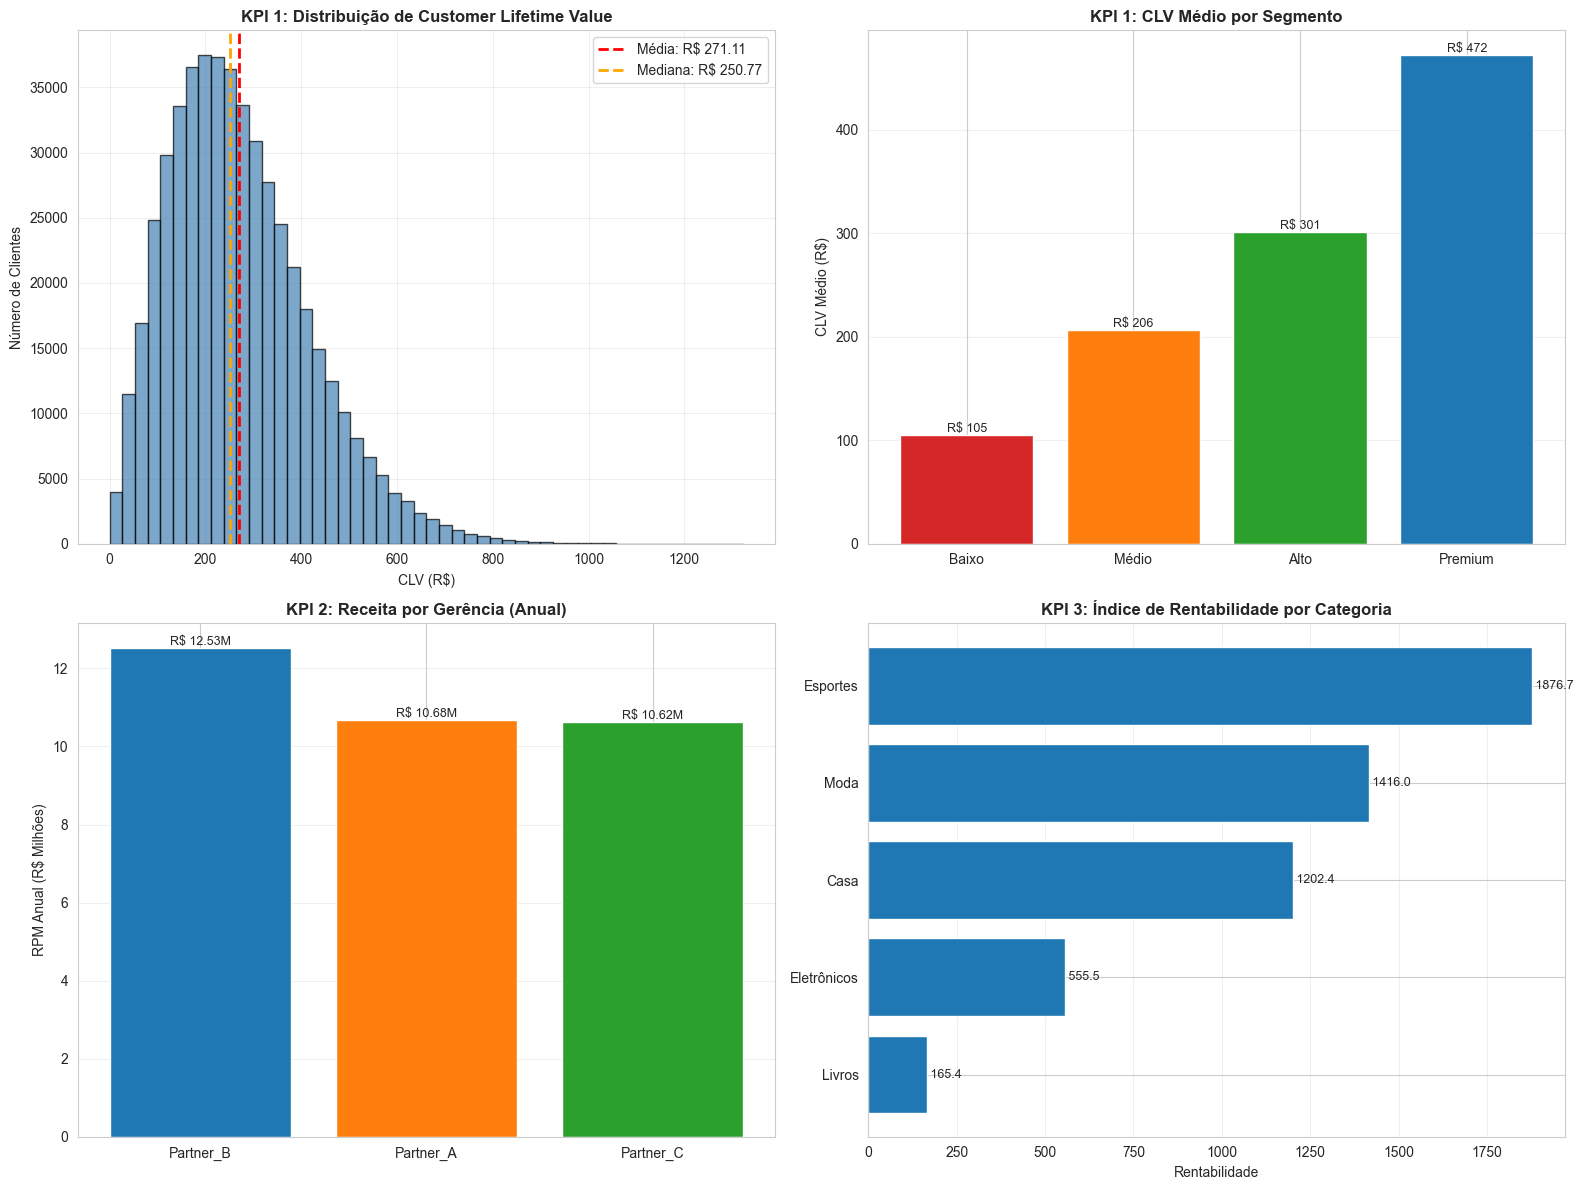

In [44]:
print("="*70)
print("CÁLCULO DE KPIs ESTRATÉGICOS")
print("="*70)


# Adicionar informações temporais
df['ano'] = df['transaction_date'].dt.year
df['mes'] = df['transaction_date'].dt.month
df['ano_mes'] = df['transaction_date'].dt.to_period('M')

print(f"Período analisado: {df['transaction_date'].min().date()} a {df['transaction_date'].max().date()}")

# ============================================
# KPI 1: CUSTOMER LIFETIME VALUE (CLV)
# ============================================
print("\n" + "="*70)
print("KPI 1: CUSTOMER LIFETIME VALUE (CLV)")
print("="*70)
print("\nDescrição:")
print("  Valor médio que cada cliente gera na plataforma por todo o período")

# Calcular CLV por cliente
clv_cliente = df.groupby('customer_id').agg({
    'receita_plataforma': 'sum',
    'transaction_id': 'count',
    'transaction_date': ['min', 'max']
}).reset_index()

clv_cliente.columns = ['customer_id', 'receita_plataforma', 'qtde_transacao', 'primeira_compra', 'ultima_compra']
clv_cliente['lifetime_dias'] = (pd.to_datetime(clv_cliente['ultima_compra']) - 
                                  pd.to_datetime(clv_cliente['primeira_compra'])).dt.days

# Métricas agregadas
media_clv = clv_cliente['receita_plataforma'].mean()
mediana_clv = clv_cliente['receita_plataforma'].median()
total_clv = clv_cliente['receita_plataforma'].sum()

print(f"\nResultados:")
print(f"  • CLV Médio: R$ {media_clv:,.2f}")
print(f"  • CLV Mediano: R$ {mediana_clv:,.2f}")
print(f"  • CLV Total (base): R$ {total_clv:,.2f}")
print(f"  • Número de clientes: {len(clv_cliente):,}")

# Segmentação por valor
clv_cliente['segmento_clv'] = pd.qcut(clv_cliente['receita_plataforma'], 
                                       q=4, 
                                       labels=['Baixo', 'Médio', 'Alto', 'Premium'])

distribuicao_segmento = clv_cliente['segmento_clv'].value_counts()
print(f"\nDistribuição por Segmento:")
for segmento in ['Premium', 'Alto', 'Médio', 'Baixo']:
    count = distribuicao_segmento.get(segmento, 0)
    pct = (count / len(clv_cliente)) * 100
    media_receita = clv_cliente[clv_cliente['segmento_clv'] == segmento]['receita_plataforma'].mean()
    print(f"  • {segmento}: {count:,} clientes ({pct:.1f}%) - CLV médio: R$ {media_receita:,.2f}")

print(f"\nAplicação Estratégica:")
print(f"  Identificar os clientes mais valiosos e ter uma gestão mais efetiva de gastos")
print(f"  2. Desenvolver programas de fidelidade para clientes de alto CLV")
print(f"  3. Identificar características de clientes Premium para aquisição")

# ============================================
# KPI 2: RECEITA POR GERENTE PARCEIRO
# ============================================
print("\n" + "="*70)
print("KPI 2: RECEITA POR GERENTE PARCEIRO")
print("="*70)
print("\nDescrição:")
print("  Receita média por parceiro para avaliação e identificação de melhorias")

# Dados do contexto: 3 parceiros, cada um com 1 gerente + 2 analistas
time_parceiro = {
    'Partner_A': {'gerentes': 1, 'analistas': 2},
    'Partner_B': {'gerentes': 1, 'analistas': 2},
    'Partner_C': {'gerentes': 1, 'analistas': 2}
}

# Calcular receita por parceiro
receita_parceiro_v2 = df.groupby('partnership').agg({
    'receita_plataforma': 'sum',
    'transaction_id': 'count',
    'total_value': 'sum'
}).reset_index()

receita_parceiro_v2.columns = ['partnership', 'receita_plataforma', 'qtde_transacao', 'valor_total_parceiro']

# Adicionar informações de equipe
receita_parceiro_v2['quantidade_gerentes'] = receita_parceiro_v2['partnership'].map(
    lambda x: time_parceiro[x]['gerentes']
)
receita_parceiro_v2['quantidade_analistas'] = receita_parceiro_v2['partnership'].map(
    lambda x: time_parceiro[x]['analistas']
)
receita_parceiro_v2['tamanho_time'] = receita_parceiro_v2['quantidade_gerentes'] + receita_parceiro_v2['quantidade_analistas']

# Calcular Receita por Gerencia (anual)
anos_data = (df['transaction_date'].max() - df['transaction_date'].min()).days / 365.25
receita_parceiro_v2['receita_gerente_anual'] = receita_parceiro_v2['receita_plataforma'] / (receita_parceiro_v2['quantidade_gerentes'] * anos_data)
receita_parceiro_v2['receita_membro_equipe'] = receita_parceiro_v2['receita_plataforma'] / (receita_parceiro_v2['tamanho_time'] * anos_data)

print(f"\nResultados (média anual por {anos_data:.1f} anos):")
for _, row in receita_parceiro_v2.sort_values('receita_gerente_anual', ascending=False).iterrows():
    print(f"\n  {row['partnership']}:")
    print(f"    • Receita total: R$ {row['receita_plataforma']:,.2f}")
    print(f"    • Receita por Gerente Anual: R$ {row['receita_gerente_anual']:,.2f}")
    print(f"    • Receita por membro do time/ano: R$ {row['receita_membro_equipe']:,.2f}")
    print(f"    • Transações: {row['qtde_transacao']:,}")

media_receitaparceiro = receita_parceiro_v2['receita_gerente_anual'].mean()
print(f"\n  Média geral RPM: R$ {media_receitaparceiro:,.2f}/gerente/ano")

print(f"\nAplicação Estratégica:")
print(f"  1. Benchmarkem relação a perfomance com outros parceiros")
print(f"  2. Identificar necessidade de reforço em times com baixa receita")
print(f"  3. Definir metas de receita por gerente para avaliação de performance")

# ============================================
# KPI 3: RENTABILIDADE POR CATEGORIA 
# ============================================
print("\n" + "="*70)
print("KPI 3: RENTABILIDADE POR CATEGORIA)")
print("="*70)
print("\nDescrição:")
print(" Verificar a rentabilidade por categoria")


# Dados do contexto: 5 categorias, cada uma com 1 gerente + 3 analistas
custo_categoria = {
    'Eletrônicos': 800000,  # Maior complexidade técnica
    'Esportes': 600000,
    'Casa': 600000,
    'Moda': 500000,  # Maior volume, processos mais padronizados
    'Livros': 500000
}

# Calcular métricas por categoria
metricas_categoria = df.groupby('category').agg({
    'receita_plataforma': 'sum',
    'transaction_id': 'count',
    'total_value': 'sum'
}).reset_index()

metricas_categoria.columns = ['category', 'receita_plataforma', 'qtde_transacao', 'valor_total_parceiro']

# Adicionar custos e calcular lucro
metricas_categoria['custo_anual'] = metricas_categoria['category'].map(custo_categoria)
metricas_categoria['custo_total'] = metricas_categoria['custo_anual'] * anos_data
metricas_categoria['diff_lucro'] = metricas_categoria['receita_plataforma'] - metricas_categoria['custo_total']
metricas_categoria['margem_lucro'] = (metricas_categoria['diff_lucro'] / metricas_categoria['receita_plataforma']) * 100
metricas_categoria['retorno'] = (metricas_categoria['diff_lucro'] / metricas_categoria['custo_total']) * 100



print(f"\nResultados (período de {anos_data:.1f} anos):")
for _, row in metricas_categoria.sort_values('retorno', ascending=False).iterrows():
    print(f"\n  {row['category']}:")
    print(f"    • Receita: R$ {row['receita_plataforma']:,.2f}")
    print(f"    • Custo estimado: R$ {row['custo_total']:,.2f}")
    print(f"    • Lucro líquido: R$ {row['diff_lucro']:,.2f}")
    print(f"    • Margem: {row['margem_lucro']:.2f}%")
    print(f"    • Retorno sobre Ivestimento: {row['retorno']:.2f}%")


print(f"\nAplicação Estratégica:")
print(f"  Priorizar os investimentos em categorias que são mais rentáveis e revisar rota para baixa rentabilidade")



# ============================================
# VISUALIZAÇÕES DOS KPIs
# ============================================
print("\nCriando visualizações dos KPIs...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# KPI 1: Distribuição de CLV
axes[0, 0].hist(clv_cliente['receita_plataforma'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(media_clv, color='red', linestyle='--', linewidth=2, label=f'Média: R$ {media_clv:.2f}')
axes[0, 0].axvline(mediana_clv, color='orange', linestyle='--', linewidth=2, label=f'Mediana: R$ {mediana_clv:.2f}')
axes[0, 0].set_xlabel('CLV (R$)')
axes[0, 0].set_ylabel('Número de Clientes')
axes[0, 0].set_title('KPI 1: Distribuição de Customer Lifetime Value', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# KPI 1b: CLV por segmento
media_segmento = clv_cliente.groupby('segmento_clv')['receita_plataforma'].mean().reindex(['Baixo', 'Médio', 'Alto', 'Premium'])
axes[0, 1].bar(range(len(media_segmento)), media_segmento.values, color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
axes[0, 1].set_xticks(range(len(media_segmento)))
axes[0, 1].set_xticklabels(media_segmento.index)
axes[0, 1].set_ylabel('CLV Médio (R$)')
axes[0, 1].set_title('KPI 1: CLV Médio por Segmento', fontsize=12, fontweight='bold')
for i, v in enumerate(media_segmento.values):
    axes[0, 1].text(i, v, f'R$ {v:,.0f}', ha='center', va='bottom', fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# KPI 2: Receita anual por parceiro
rpm_data = receita_parceiro_v2.sort_values('receita_gerente_anual', ascending=False)
axes[1, 0].bar(range(len(rpm_data)), rpm_data['receita_gerente_anual'].values / 1e6, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 0].set_xticks(range(len(rpm_data)))
axes[1, 0].set_xticklabels(rpm_data['partnership'].values)
axes[1, 0].set_ylabel('RPM Anual (R$ Milhões)')
axes[1, 0].set_title('KPI 2: Receita por Gerência (Anual)', fontsize=12, fontweight='bold')
for i, v in enumerate(rpm_data['receita_gerente_anual'].values):
    axes[1, 0].text(i, v / 1e6, f'R$ {v/1e6:.2f}M', ha='center', va='bottom', fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# KPI 3: Rentabilidade por categoria
rentabilidade_data = metricas_categoria.sort_values('retorno', ascending=False)
axes[1, 1].barh(range(len(rentabilidade_data)), rentabilidade_data['retorno'].values)
axes[1, 1].set_yticks(range(len(rentabilidade_data)))
axes[1, 1].set_yticklabels(rentabilidade_data['category'].values)
axes[1, 1].set_xlabel('Rentabilidade')
axes[1, 1].set_title('KPI 3: Índice de Rentabilidade por Categoria', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
for i, v in enumerate(rentabilidade_data['retorno'].values):
    axes[1, 1].text(v, i, f' {v:.1f}', va='center', fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()


print("\n" + "="*70)
print("CÁLCULO DE KPIs CONCLUÍDO COM SUCESSO!")
print("="*70)

plt.show()